In [108]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
import skforecast
from sklearn.metrics import root_mean_squared_error
from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import grid_search_forecaster
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.linear_model import Ridge
import xgboost as xgb
import lightgbm as lgb
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import pmdarima as pm  # Modelado ARIMA automático
from statsmodels.tsa.statespace.sarimax import SARIMAX  # Modelado SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose # type: ignore
import warnings

In [ ]:
df = pd.read_csv("../data/transformed/Alcala_Henares/datos_Alcala_Henares_transformados.csv")

In [3]:
df.dtypes

fecha        object
tmed        float64
tmin        float64
tmax        float64
velmedia    float64
hrMedia     float64
dtype: object

In [4]:
df[["año","mes","dia"]] = df["fecha"].str.split("-", expand=True).astype(int)

### AÑADIENDO VARIABLES EXÓGENAS

In [5]:

for i, mes in enumerate(df["mes"]):
    if mes in [12, 1, 2]:
        df.loc[i, "estacion"] = "Invierno"
    elif mes in [3, 4, 5]:
        df.loc[i, "estacion"] = "Primavera"
    elif mes in [6, 7, 8]:
        df.loc[i, "estacion"] = "Verano"
    else:
        df.loc[i, "estacion"] = "Otoño"
        

In [6]:
# Calcula la media de "tmed" por grupo ("mes" y "dia") y asigna el resultado a una nueva columna
df["temp_med_dia_mes"] = df.groupby(["mes", "dia"])["tmed"].transform("mean")



In [7]:
df.dtypes

fecha                object
tmed                float64
tmin                float64
tmax                float64
velmedia            float64
hrMedia             float64
año                   int32
mes                   int32
dia                   int32
estacion             object
temp_med_dia_mes    float64
dtype: object

In [8]:
df_encoded = pd.get_dummies(df["estacion"], dtype = int, drop_first=True)

In [9]:
df[["Otoño","Primavera","Verano"]] = df_encoded

In [10]:
df.head(2)

,fecha,tmed,tmin,tmax,velmedia,hrMedia,año,mes,dia,estacion,temp_med_dia_mes,Otoño,Primavera,Verano
0,2019-01-01,5.3,-4.1,14.7,0.8,62.0,2019,1,1,Invierno,6.428571,0,0,0
1,2019-01-02,4.6,-5.5,14.6,1.1,65.0,2019,1,2,Invierno,5.400000,0,0,0


## PREDICCIÓN TEMPERATURA MEDIA

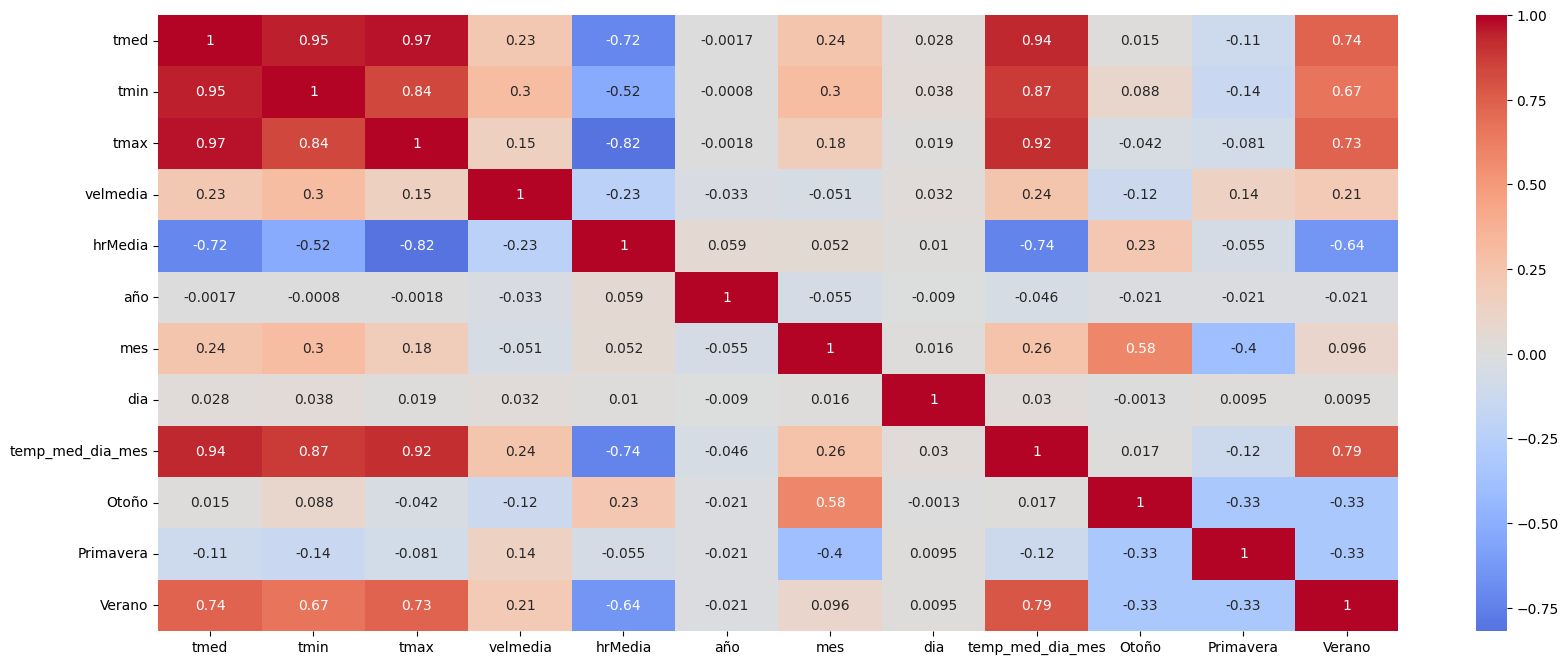

In [11]:
# Se puede observar que para predecir la temperatura media el mes tiene importancia
plt.figure(figsize=(20, 8))
correlation_matrix = df.corr(numeric_only=True)

# Crear un mapa de calor para visualizar la matriz de correlación
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.show()

In [12]:
df["MONTH_SIN"] = np.sin(2 * np.pi * df["mes"] / 12)
df["MONTH_COS"] = np.cos(2 * np.pi * df["mes"] / 12)

In [13]:
df.columns

Index(['fecha', 'tmed', 'tmin', 'tmax', 'velmedia', 'hrMedia', 'año', 'mes',
       'dia', 'estacion', 'temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano',
       'MONTH_SIN', 'MONTH_COS'],
      dtype='object')

In [14]:
df_temp_med = df.drop(columns=['fecha', 'tmin', 'tmax', 'velmedia', 'hrMedia', 'año','mes','dia','estacion'])

In [15]:
df_temp_med.head(2)

,tmed,temp_med_dia_mes,Otoño,Primavera,Verano,MONTH_SIN,MONTH_COS
0,5.3,6.428571,0,0,0,0.5,0.866025
1,4.6,5.400000,0,0,0,0.5,0.866025


In [16]:
df_temp_med.columns

Index(['tmed', 'temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano', 'MONTH_SIN',
       'MONTH_COS'],
      dtype='object')

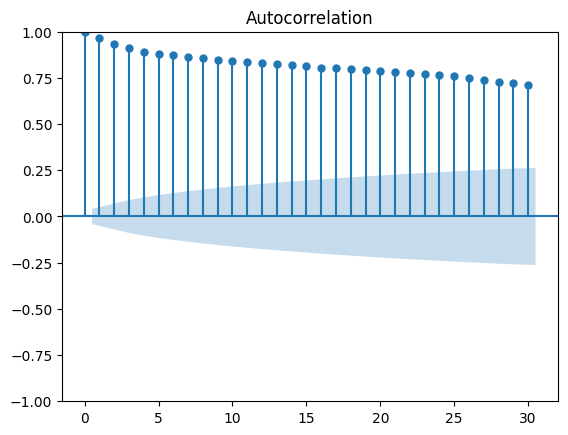

In [17]:
# Grafica que representa la correlacion entre los lags escogidos y la temperatura actual y se ve que si los lags son cercanos a 1 hay mucha correlacion
plot_acf(df['tmed'], lags=30)  # Analiza los primeros 30 lags
plt.show()

## FORECASTER RECURSIVE

In [18]:
train_size = int(len(df_temp_med)*0.9)

data_train = df_temp_med.iloc[:train_size]
data_train = data_train[['tmed','temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS']]
data_test = df_temp_med.iloc[train_size:]
data_test = data_test[['tmed','temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS']]

### RANDOM FOREST RECURSIVE

In [ ]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(random_state=2517,criterion= 'squared_error',
                #  n_estimators=6,
                #  max_depth=3,
                #  min_samples_split=5
                 ),
                 lags      = 6
             )
forecaster.fit(y=data_train['tmed'], exog = data_train[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS']])

# Hago una prediccion para todos los valores de test
predictions = forecaster.predict(steps=224, exog = data_test[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS']])

# Para saber cuantos steps coger, cojo 224 setps
y_buena = df_temp_med[2009:]
y_buena = y_buena["tmed"]

# -------------SIN TUNEAR-------------------
# Con steps = 224, rmse = 2.515204078360953
# Con steps = 7, rmse = 1.576100295938406
# Con steps = 1, rmse = 1.730000000000004

# -------------TUNEADO-------------------
# Mejor no pongo resultados

rmse =  root_mean_squared_error(y_buena, predictions)
rmse

=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [1 2 3 4 5 6] 
Window features: None 
Window size: 6 
Exogenous included: True 
Exogenous names: 
    temp_med_dia_mes, Otoño, Primavera, Verano, MONTH_SIN, MONTH_COS 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [0, 2008] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 2517, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-02-26 11:28:39 
Last fit date: 2025-02-26 11:28:41 
Skforecast version: 0.14.0 
Python version: 3.12.0 
Forecaster id: None

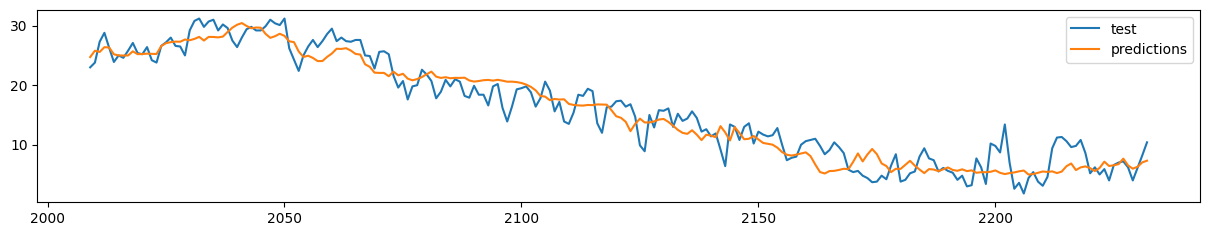

In [28]:
# Se puede oberservar que las predicciones parecen estar bien(si ponemos un valor como 12) pero si se 
# incrementa los steps a 100 o mas sale una linea recta
fig, ax = plt.subplots(figsize=(15, 2.5))
data_test['tmed'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

### RIDGE RECURSIVE

In [79]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = Ridge(random_state=2517,
                                #    alpha=599.484250
                #  n_estimators=6,
                #  max_depth=3,
                #  min_samples_split=5
                 ),
                 lags      = 6
             )
forecaster.fit(y=data_train['tmed'], exog = data_train[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS']])

# Hago una prediccion para todos los valores de test
predictions = forecaster.predict(steps=224, exog = data_test[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS']])

# Para saber cuantos steps coger, cojo 224 setps
y_buena = df_temp_med[2009:]
y_buena = y_buena["tmed"]


# -------------SIN TUNEAR-------------------
# Con steps = 224, rmse = 2.485420468942971
# Con steps = 7, rmse = 1.6533186312082653
# Con steps = 1, rmse = 1.730000000000004

# -------------TUNEADO-------------------
# Con steps = 224, rmse = 2.403206562110449
# Con steps = 7, rmse = 1.6682765038710474

rmse =  root_mean_squared_error(y_buena, predictions)
rmse

2.485420468942971

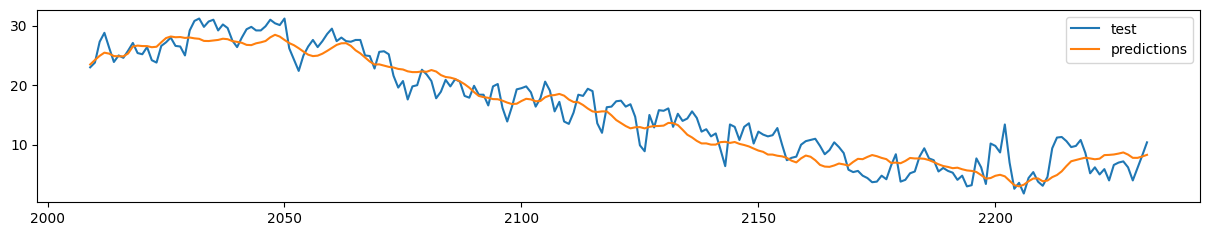

In [80]:
# Se puede oberservar que las predicciones parecen estar bien(si ponemos un valor como 12) pero si se 
# incrementa los steps a 100 o mas sale una linea recta
fig, ax = plt.subplots(figsize=(15, 2.5))
data_test['tmed'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

### XGBOOST RECURSIVE

In [75]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = xgb.XGBRegressor(random_state=2517,                
                # colsample_bytree= 0.8, 
                # learning_rate= 0.1, 
                # max_depth=3, 
                # n_estimators= 50, 
                # subsample= 0.8
                 ),
                 lags      = 6
             )
forecaster.fit(y=data_train['tmed'], exog = data_train[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS']])


# Hago una prediccion para todos los valores de test
predictions = forecaster.predict(steps=224, exog = data_test[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS']])

# Para saber cuantos steps coger, cojo 224 setps
y_buena = df_temp_med[2009:]
y_buena = y_buena["tmed"]

# -------------SIN TUNEAR-------------------
# Con steps = 224, rmse = 2.7858691059154825
# Con steps = 7, rmse = 2.156953838632458
# Con steps = 1, rmse = 1.730000000000004

# -------------TUNEADO-------------------
# Con steps = 224, rmse = 2.480180783043909
# Con steps = 7, rmse = 1.7693091435366928

rmse =  root_mean_squared_error(y_buena, predictions)
rmse

2.7858691059154825

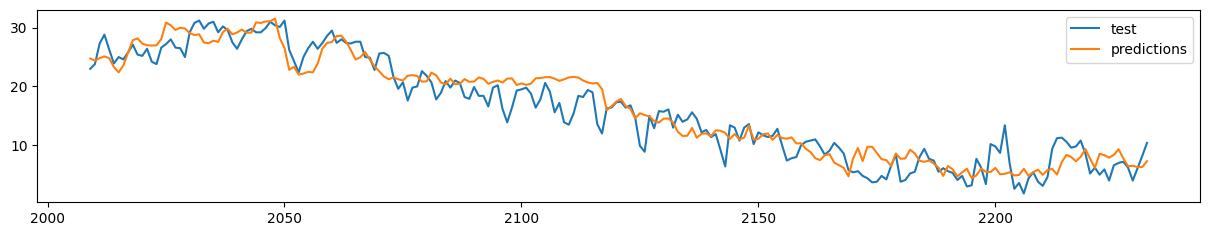

In [76]:
# Se puede oberservar que las predicciones parecen estar bien(si ponemos un valor como 12) pero si se 
# incrementa los steps a 100 o mas sale una linea recta
fig, ax = plt.subplots(figsize=(15, 2.5))
data_test['tmed'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

### LIGHTGBM RECURSIVE

In [ ]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = lgb.LGBMRegressor(random_state=2517,
                                            #    boosting_type= 'gbdt', 
                                            #    colsample_bytree= 0.8, 
                                            #    learning_rate= 0.1, 
                                            #    max_depth= 2, 
                                            #    n_estimators= 100,
                                            #    reg_lambda= 1              
               
                 ),
                 lags      = 6
             )
forecaster.fit(y=data_train['tmed'], exog = data_train[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS']])


# Hago una prediccion para todos los valores de test
predictions = forecaster.predict(steps=224, exog = data_test[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS']])

# Para saber cuantos steps coger, cojo 224 setps
y_buena = df_temp_med[2009:]
y_buena = y_buena["tmed"]

# -------------SIN TUNEAR-------------------
# Con steps = 224, rmse = 2.535112943461391
# Con steps = 7, rmse = 1.9877118683211634
# Con steps = 1, rmse = 1.730000000000004

# -------------TUNEADO-------------------
# Aunque los resultados son ligeramente mejores, la grafica de abajo empeora

rmse =  root_mean_squared_error(y_buena, predictions)
rmse

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1757
[LightGBM] [Info] Number of data points in the train set: 2003, number of used features: 12
[LightGBM] [Info] Start training from score 15.161333


2.535112943461391

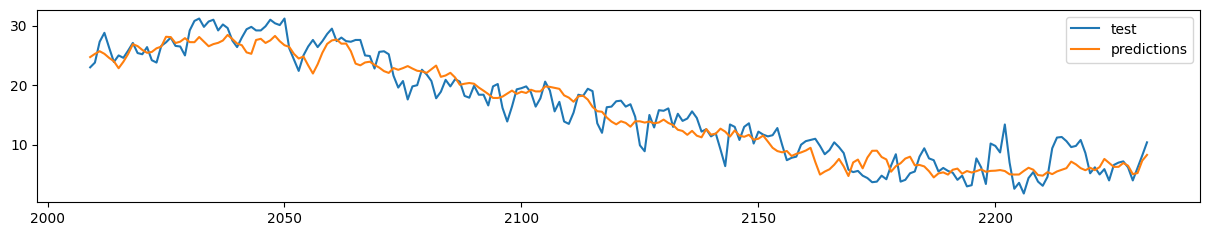

In [74]:
# Se puede oberservar que las predicciones parecen estar bien(si ponemos un valor como 12) pero si se 
# incrementa los steps a 100 o mas sale una linea recta
fig, ax = plt.subplots(figsize=(15, 2.5))
data_test['tmed'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

### ------------------------------------------------------------------------------------------------------------------------
### ------------------------------------------------------------------------------------------------------------------------
### ------------------------------------------------------------------------------------------------------------------------

## DIRECT FORECASTER

### Ridge, sin escalador, con columnas exógenas

In [167]:
# Hyperparameter Grid search
# ==============================================================================
from skforecast.exceptions import LongTrainingWarning
warnings.simplefilter('ignore', category=LongTrainingWarning)

forecaster = ForecasterDirect(
                 regressor     = Ridge(random_state=2517),
                 steps         = 7,
                 lags          = 1,  # This value will be replaced in the grid search
                 transformer_y = None,
             )

cv = TimeSeriesFold(
         steps              = 7, 
         initial_train_size = int(len(df_temp_med) * 0.9),
         fixed_train_size   = False,
         refit              = False,
)

param_grid = {'alpha': np.logspace(-5, 5, 10)}

lags_grid = [5, 12, 20]

results_grid = grid_search_forecaster(
                    forecaster         = forecaster,
                    y                  = df_temp_med['tmed'],
                    cv                 = cv,
                    exog= df_temp_med[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS']],
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    metric             = 'mean_squared_error',
                    return_best        = True,
                    n_jobs             = 'auto',
                    verbose            = False)

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'alpha': 599.4842503189421}
  Backtesting metric: 5.423993263415892


In [168]:
# Search results
# ==============================================================================

# Mas o menos en el mejor de los casos me equivoco en 1,93 grados con 1 steps y sin columnas exogenas

# Mas o menos en el mejor de los casos me equivoco en 2,32 grados con 7 steps y columnas exogenas
# Mas o menos en el mejor de los casos me equivoco en 1,80 grados con 1 steps y columnas exogenas
results_grid

,lags,lags_label,params,mean_squared_error,alpha
0,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]",{'alpha': 599.4842503189421},5.423993,599.484250
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 599.4842503189421},5.485808,599.484250
2,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]",{'alpha': 46.41588833612782},5.513816,46.415888
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 599.4842503189421},5.546240,599.484250
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'alpha': 46.41588833612782},5.575771,46.415888
5,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]",{'alpha': 3.593813663804626},5.576745,3.593814
6,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]",{'alpha': 0.2782559402207126},5.587015,0.278256
7,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]",{'alpha': 0.021544346900318846},5.587889,0.021544
8,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]",{'alpha': 0.0016681005372000592},5.587957,0.001668
9,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]",{'alpha': 0.0001291549665014884},5.587963,0.000129


In [169]:
df_predicciones = df_temp_med[-7:]
dic = {"temp_med_dia_mes":[8.328571,8.585714,7.200000,6.557143,7.585714,8.042857,8.385714]
       ,"Otoño":[0,0,0,0,0,0,0]
       ,"Primavera":[0,0,0,0,0,0,0]
       ,"Verano":[0,0,0,0,0,0,0]
       , "MONTH_SIN":[0.866025,0.866025,0.866025,0.866025,0.866025,0.866025,0.866025]
       ,"MONTH_COS":[0.5,0.5,0.5,0.5,0.5,0.5,0.5]}

df_nuevos_datos = pd.DataFrame(dic)


# Concatenar el DataFrame existente con los nuevos datos
df_predicciones = pd.concat([df_predicciones, df_nuevos_datos], ignore_index=True)

# Modificar index para que se crea que hemos metido nuevos registros 
df_predicciones = df_predicciones[-7:]
df_predicciones.index= [2233,2234,2235,2236,2237,2238,2239]


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\skforecast\utils\utils.py:1292: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


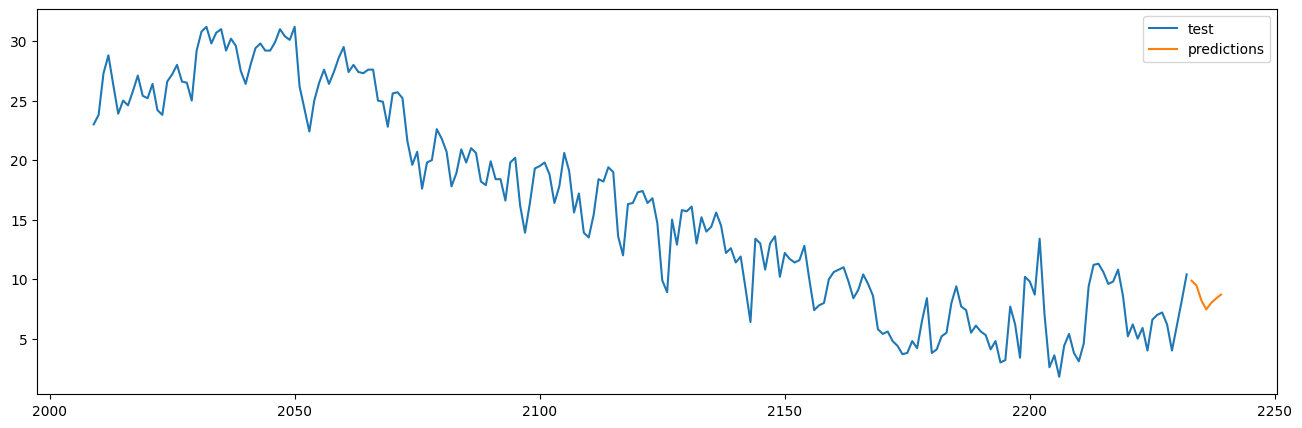

In [170]:
# ==============================================================================
predictions = forecaster.predict( exog = df_predicciones[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS']])

# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(16, 5))
data_test['tmed'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

### RANDOM FOREST

In [171]:
# Hyperparameter Grid search
# ==============================================================================
from skforecast.exceptions import LongTrainingWarning
warnings.simplefilter('ignore', category=LongTrainingWarning)

forecaster = ForecasterDirect(
                 regressor     = RandomForestRegressor(random_state=2517),
                 steps         = 7,
                 lags          = 1,  # This value will be replaced in the grid search
                 transformer_y = None
             )

cv = TimeSeriesFold(
         steps              = 7, 
         initial_train_size = int(len(df_temp_med) * 0.9),
         fixed_train_size   = False,
         refit              = False,
)

param_grid = {'criterion': ['squared_error', 'absolute_error'],
              'n_estimators':[2,4,6,8,10,20,50,100],
              'max_depth':[2,3,4,5,6],
              'min_samples_split':[2,3,4,5]}

lags_grid = [5, 12, 20]

results_grid = grid_search_forecaster(
                    forecaster         = forecaster,
                    y                  = df_temp_med['tmed'],
                    exog= df_temp_med[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS']],
                    cv                 = cv,
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    metric             = 'mean_squared_error',
                    return_best        = True,
                    n_jobs             = 'auto',
                    verbose            = False)

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/320 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'criterion': 'squared_error', 'max_depth': 5, 'min_samples_split': 3, 'n_estimators': 6}
  Backtesting metric: 5.817478546387262


In [ ]:
# Search results
# ==============================================================================

# Mas o menos en el mejor de los casos me equivoco en 1.90 grados con 1 steps y sin columnas exogenas

# Mas o menos en el mejor de los casos me equivoco en 2,41 grados con 7 steps y con columnas exogenas
results_grid

,lags,lags_label,params,mean_squared_error,criterion,max_depth,min_samples_split,n_estimators
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'criterion': 'squared_error', 'max_depth': 5,...",5.817479,squared_error,5,3,6
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'criterion': 'squared_error', 'max_depth': 5,...",5.817479,squared_error,5,4,6
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'criterion': 'squared_error', 'max_depth': 5,...",5.817479,squared_error,5,2,6
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'criterion': 'squared_error', 'max_depth': 5,...",5.817479,squared_error,5,5,6
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'criterion': 'squared_error', 'max_depth': 5,...",5.854209,squared_error,5,3,8
...,...,...,...,...,...,...,...,...
955,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'criterion': 'absolute_error', 'max_depth': 2...",7.993836,absolute_error,2,3,2
956,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'criterion': 'squared_error', 'max_depth': 2,...",8.114269,squared_error,2,4,2
957,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'criterion': 'squared_error', 'max_depth': 2,...",8.114269,squared_error,2,3,2
958,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'criterion': 'squared_error', 'max_depth': 2,...",8.114269,squared_error,2,5,2


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\skforecast\utils\utils.py:1292: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


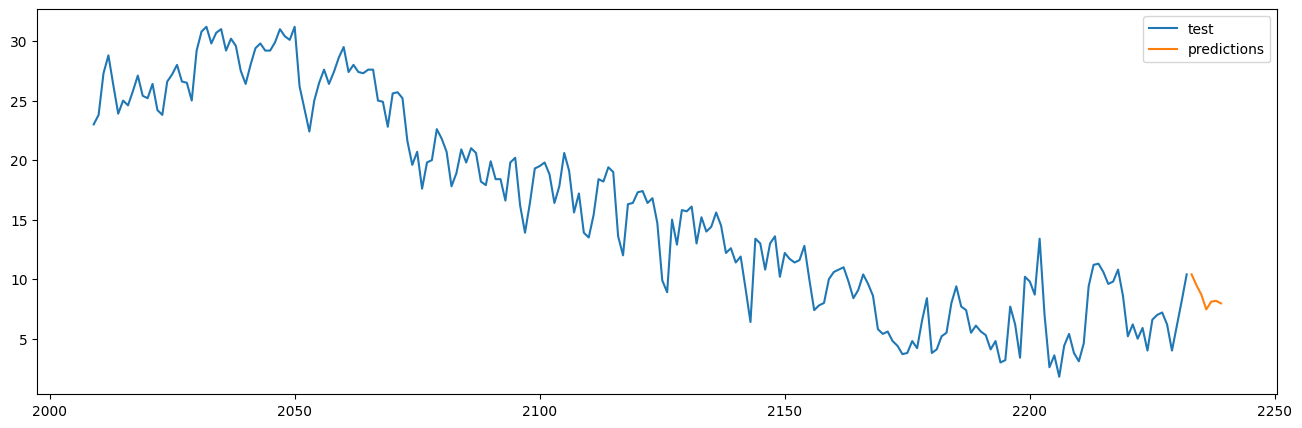

In [173]:
# ==============================================================================
predictions = forecaster.predict( exog = df_predicciones[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS']])

# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(16, 5))
data_test['tmed'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

### XGBOOST

In [176]:
# Hyperparameter Grid search
# ==============================================================================
from skforecast.exceptions import LongTrainingWarning
warnings.simplefilter('ignore', category=LongTrainingWarning)

forecaster = ForecasterDirect(
                 regressor     = xgb.XGBRegressor(random_state = 2517),
                 steps         = 7,
                 lags          = 1,  # This value will be replaced in the grid search
                 transformer_y = None
             )

cv = TimeSeriesFold(
         steps              = 7, 
         initial_train_size = int(len(df_temp_med) * 0.9),
         fixed_train_size   = False,
         refit              = False,
)

param_grid = {'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [2,4,6,8,10,20,50,100],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]}

lags_grid = [5, 12, 20]

results_grid = grid_search_forecaster(
                    forecaster         = forecaster,
                    y                  = df_temp_med['tmed'],
                    cv                 = cv,
                    exog= df_temp_med[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS']],
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    metric             = 'mean_squared_error',
                    return_best        = True,
                    n_jobs             = 'auto',
                    verbose            = False)

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/288 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
  Backtesting metric: 5.736632616610602


In [ ]:
# Search results
# ==============================================================================

# Mas o menos en el mejor de los casos me equivoco en 1.92 grados con steps 1 y sin columnas exogenas

# Mas o menos en el mejor de los casos me equivoco en 1.80 grados con steps 1 y con columnas exogenas
# Mas o menos en el mejor de los casos me equivoco en 2.39 grados con steps 7 y con columnas exogenas
results_grid

,lags,lags_label,params,mean_squared_error,colsample_bytree,learning_rate,max_depth,n_estimators,subsample
0,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'colsample_bytree': 0.8, 'learning_rate': 0.1...",5.736633,0.8,0.10,3.0,50.0,0.8
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.8, 'learning_rate': 0.2...",5.794118,0.8,0.20,3.0,20.0,0.8
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'colsample_bytree': 0.8, 'learning_rate': 0.1...",5.835414,0.8,0.10,3.0,50.0,0.8
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'colsample_bytree': 0.8, 'learning_rate': 0.1...",5.839770,0.8,0.10,3.0,50.0,0.8
4,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'colsample_bytree': 0.8, 'learning_rate': 0.2...",5.842540,0.8,0.20,3.0,20.0,0.8
...,...,...,...,...,...,...,...,...,...
859,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'colsample_bytree': 0.8, 'learning_rate': 0.0...",71.649852,0.8,0.01,3.0,2.0,0.8
860,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'colsample_bytree': 1.0, 'learning_rate': 0.0...",71.660871,1.0,0.01,7.0,2.0,1.0
861,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'colsample_bytree': 1.0, 'learning_rate': 0.0...",71.669377,1.0,0.01,3.0,2.0,1.0
862,"[1, 2, 3, 4, 5]","[1, 2, 3, 4, 5]","{'colsample_bytree': 0.8, 'learning_rate': 0.0...",71.669377,0.8,0.01,3.0,2.0,1.0


In [ ]:
# ==============================================================================
predictions = forecaster.predict( exog = df_predicciones[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS']])

# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(16, 5))
data_test['tmed'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

### LIGHTGBM

In [181]:
# Hyperparameter Grid search
# ==============================================================================
from skforecast.exceptions import LongTrainingWarning
warnings.simplefilter('ignore', category=LongTrainingWarning)

forecaster = ForecasterDirect(
                 regressor     = lgb.LGBMRegressor(random_state=2517),
                 steps         = 7,
                 lags          = 1,  # This value will be replaced in the grid search
                 transformer_y = None
             )

cv = TimeSeriesFold(
         steps              = 7, 
         initial_train_size = int(len(df_temp_med) * 0.9),
         fixed_train_size   = False,
         refit              = False,
)

param_grid = {'boosting_type': ['gbdt'],  # Tipo de boosting
      # Número máximo de hojas en un árbol
    'max_depth': [2, 4,6,8],  # Profundidad máxima del árbol (-1 significa sin límite)
    'learning_rate': [ 0.1,0.2],  # Tasa de aprendizaje
    'n_estimators': [2,4,6,8,10,12,16,20,50,100],  # Número de árboles (iteraciones)
    'subsample': [0.8, 1.0],  # Fracción de muestras usadas para entrenar cada árbol
    'colsample_bytree': [0.8, 1.0],  # Fracción de características usadas para cada árbol
    'reg_alpha': [0.1],  # Regularización L1 (Lasso)
    'reg_lambda': [1] # Regularización L2 (Ridge
    }

lags_grid = [5, 12, 20]

results_grid = grid_search_forecaster(
                    forecaster         = forecaster,
                    y                  = df_temp_med['tmed'],
                    cv                 = cv,
                    exog= df_temp_med[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS']],
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    metric             = 'mean_squared_error',
                    return_best        = True,
                    n_jobs             = 'auto',
                    verbose            = False)

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/320 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1510
[LightGBM] [Info] Number of data points in the train set: 2004, number of used features: 11
[LightGBM] [Info] Start training from score 15.156113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1510
[LightGBM] [Info] Number of data points in the train set: 2004, number of used features: 11
[LightGBM] [Info] Start training from score 15.156113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

In [ ]:
# Search results
# ==============================================================================

# Mas o menos en el mejor de los casos me equivoco en 1.92 grados con steps 1 y sin columnas exogenas

# Mas o menos en el mejor de los casos me equivoco en 1,79 grados con steps 1 y con columnas exogenas
# Mas o menos en el mejor de los casos me equivoco en 2,43 grados con steps 7 y con columnas exogenas

results_grid.head(1)

,lags,lags_label,params,mean_squared_error,boosting_type,colsample_bytree,learning_rate,max_depth,n_estimators,reg_alpha,reg_lambda,subsample
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'boosting_type': 'gbdt', 'colsample_bytree': ...",5.909038,gbdt,0.8,0.1,2,100,0.1,1,1.0


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\skforecast\utils\utils.py:1292: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


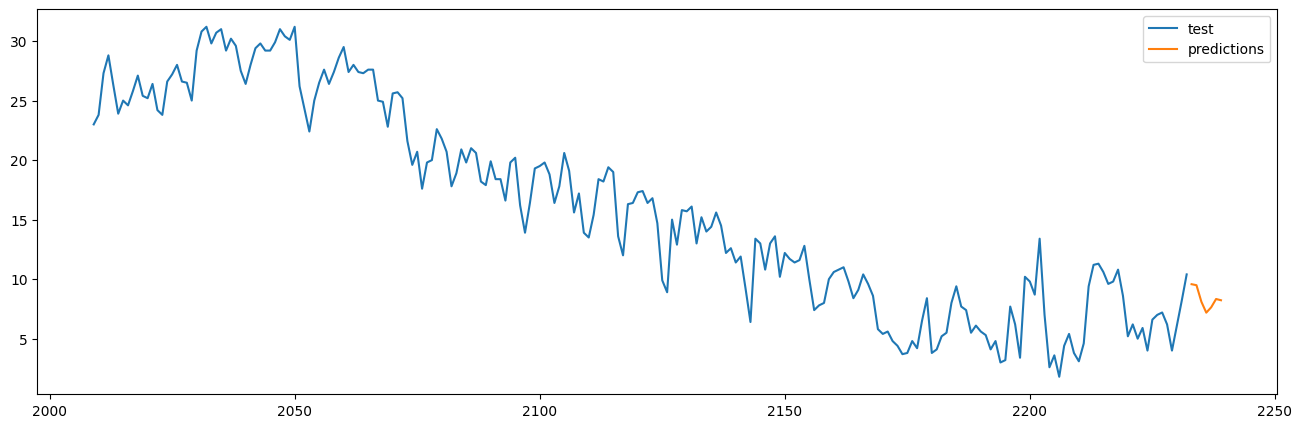

In [180]:
# ==============================================================================
predictions = forecaster.predict( exog = df_predicciones[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS']])

# Plot predictions versus test data
# ==============================================================================
fig, ax = plt.subplots(figsize=(16, 5))
data_test['tmed'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

## SARIMA

In [81]:
# Realizar el Test ADF (Dickey-Fuller Aumentado)
adf_result = adfuller(df_temp_med["tmed"])

# Imprimir los resultados del test ADF
print("Estadística de prueba ADF:", adf_result[0])
print("Valor p:", adf_result[1])
print("Valores críticos:", adf_result[4])

# Interpretación del resultado
if adf_result[1] < 0.05:
    print("Rechazamos la hipótesis nula: La serie es estacionaria")
else:
    print("No podemos rechazar la hipótesis nula: La serie tiene una raíz unitaria y no es estacionaria")

Estadística de prueba ADF: -3.100751851041439
Valor p: 0.026497598151469917
Valores críticos: {'1%': -3.4332990438642623, '5%': -2.8628427996988957, '10%': -2.567463542934827}
Rechazamos la hipótesis nula: La serie es estacionaria


In [82]:
train_size = int(len(df_temp_med)*0.9)

data_train = df_temp_med.iloc[:train_size]
y_train = data_train[["tmed"]]
data_test = df_temp_med.iloc[train_size:]
y_test = data_test[["tmed"]]

In [92]:
# Definimos el rango de parámetros para ARIMA (p, d, q)
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))  # Generamos todas las combinaciones posibles

# Inicializamos variables para guardar el mejor modelo
best_score = float("inf")  # Inicializamos con infinito
best_params = None

# Iteramos sobre las combinaciones de parámetros
for param in pdq:
    try:
        # Ajustamos el modelo ARIMA con los parámetros actuales
        mod = sm.tsa.ARIMA(y_train, order=param, exog=data_train[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS']])
        results = mod.fit()

        # Imprimimos el AIC del modelo
        print(f"ARIMA{param} - AIC:{results.aic}")

        # Guardamos el modelo con el menor AIC
        if results.aic < best_score:
            best_score = results.aic
            best_params = param
    except Exception as e:
        # Si algún modelo falla, seguimos con el resto
        print(f"ARIMA{param} falló: {e}")
        continue

# Mostramos el mejor resultado
print("\nMejor modelo:")
print(f"Parámetros: {best_params} - AIC: {best_score}")


ARIMA(0, 0, 0) - AIC:9773.985817070372
ARIMA(0, 0, 1) - AIC:8492.736269566672
ARIMA(0, 0, 2) - AIC:8140.54560298521
ARIMA(0, 1, 0) - AIC:8151.6163425669965
ARIMA(0, 1, 1) - AIC:8153.546835406623
ARIMA(0, 1, 2) - AIC:8049.366926377776
ARIMA(0, 2, 0) - AIC:9548.271956624969


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 1) - AIC:8158.180723911504


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 2, 2) - AIC:8161.228009338941


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0) - AIC:7922.625745552916


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1) - AIC:7889.010024809908


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 2) - AIC:7884.227207532931
ARIMA(1, 1, 0) - AIC:8153.573817029844


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1) - AIC:7922.643942761873


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2) - AIC:7887.523934683335
ARIMA(1, 2, 0) - AIC:9189.130271683503


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 1) - AIC:8160.149922787652


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 2, 2) - AIC:8149.794687081829


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 0) - AIC:7895.275763335323


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 1) - AIC:7885.584523012448


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2) - AIC:7885.75687552343
ARIMA(2, 1, 0) - AIC:8078.985721924135


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 1) - AIC:7893.7728260992535


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) - AIC:7884.641339461745
ARIMA(2, 2, 0) - AIC:8883.365926488745


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 2, 1) - AIC:8085.953716575889
ARIMA(2, 2, 2) - AIC:7920.285970921641

Mejor modelo:
Parámetros: (1, 0, 2) - AIC: 7884.227207532931


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [93]:
print("El mejor modelo es {}, \nCon un AIC de {}".format(best_params, best_score))

El mejor modelo es (1, 0, 2), 
Con un AIC de 7884.227207532931


In [94]:
# Hacer predicciones

forecast = results.forecast(steps=len(y_test), exog = data_test[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS']])  # Predecir sobre el conjunto de prueba
forecast_index = y_test.index

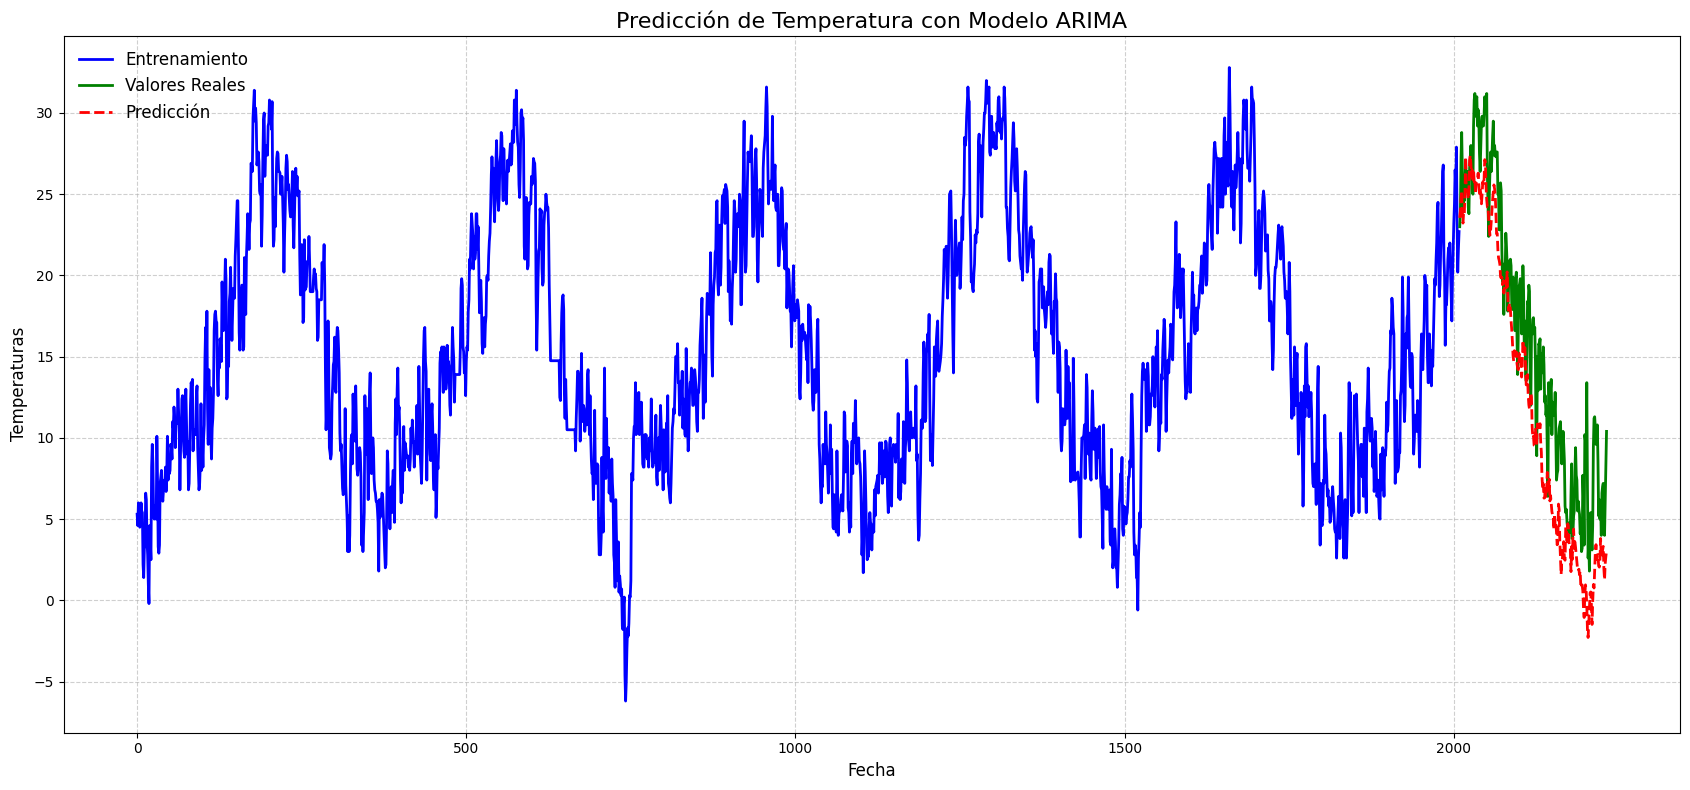

In [95]:

# Crear el gráfico
plt.figure(figsize=(17, 8))

# Graficar los valores reales
plt.plot(y_train.index, y_train, label='Entrenamiento', color='blue', linewidth=2)
plt.plot(y_test.index, y_test, label='Valores Reales', color='green', linewidth=2)

# Graficar las predicciones
plt.plot(forecast_index, forecast, label='Predicción', color='red', linewidth=2, linestyle='--')

# Añadir título y etiquetas
plt.title('Predicción de Temperatura con Modelo ARIMA', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Temperaturas', fontsize=12)

# Añadir grilla
plt.grid(True, linestyle='--', alpha=0.6)

# Mejorar la leyenda
plt.legend(loc='upper left', fontsize=12, frameon=False)

# Mostrar el gráfico
plt.tight_layout()  # Ajustar el gráfico para evitar solapamiento
plt.show()


In [88]:

rmse = sqrt(metrics.mean_squared_error(y_test, forecast))

print("El modelo ARIMA con los parametros {}, ha dado un rmse en test de {}".format(best_params, round(rmse, 2)))

El modelo ARIMA con los parametros (1, 0, 2), ha dado un rmse en test de 4.58


## PMDARIMA

### SARIMA CON PMDARIMA

c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\d

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=12.14 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=8153.616, Time=0.12 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=8157.058, Time=0.85 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=8157.048, Time=0.86 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,0)[7]             : AIC=8151.616, Time=0.83 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=8155.099, Time=0.63 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=8155.115, Time=0.68 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=8157.001, Time=2.51 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=8155.573, Time=0.40 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=8155.546, Time=0.62 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=inf, Time=9.62 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 29.407 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2009
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4068.808
Date:                Wed, 26 Feb 2025   AIC                           8151.616
Time:                        12:29:28   BIC                           8190.851
Sample:                             0   HQIC                          8166.019
                               - 2009                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
temp_med_dia_mes     1.0064      0.048     20.890      0.00

c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


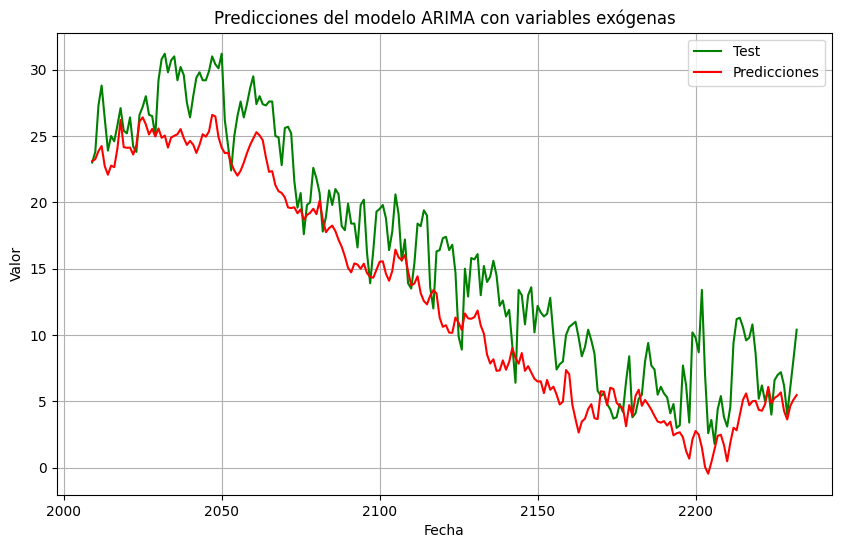

In [100]:
# 3. Ajustar el modelo ARIMA con variables exógenas
model = pm.auto_arima(
    y_train,
    X=data_train[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS']],  # Variables exógenas
    seasonal=True,  # Estacionalidad
    m=7,  # Estacionalidad anual (si los datos son mensuales)
    stepwise=True,  # Búsqueda paso a paso para encontrar los mejores parámetros
    trace=True,  # Muestra el progreso
    error_action="ignore",  # Ignora errores
    suppress_warnings=True,  # Suprime advertencias
)

# 4. Mostrar un resumen del modelo
print(model.summary())

# 5. Realizar predicciones sobre el conjunto de test
preds, conf_int = model.predict(
    n_periods=len(y_test),  # Número de períodos a predecir
    X=data_test[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS']],  # Variables exógenas para el conjunto de test
    return_conf_int=True,  # Devuelve intervalos de confianza
)

# 6. Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(data_test.index, y_test, label="Test", color="green")
plt.plot(data_test.index, preds, label="Predicciones", color="red")
plt.title("Predicciones del modelo ARIMA con variables exógenas")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.grid()
plt.show()

## SARIMAX

c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\d

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=5.77 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=13856.312, Time=0.06 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=8485.869, Time=2.08 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=10913.070, Time=0.89 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=17071.538, Time=0.03 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=8484.022, Time=0.29 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=8485.879, Time=0.47 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=4.01 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=8484.862, Time=0.58 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=8484.250, Time=0.56 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=11713.192, Time=0.41 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[7] intercept   : AIC=8472.923, Time=1.16 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,0)[7] intercept   : AIC=8474.871, Time=4.37 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,1)[7] intercept   : AIC=8474.875, Time=2.46 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=3.53 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[7] intercept   : AIC=8375.243, Time=2.35 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,0,0)[7] intercept   : AIC=8377.354, Time=6.30 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,1)[7] intercept   : AIC=8377.120, Time=6.09 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=4.71 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[7] intercept   : AIC=8428.208, Time=0.75 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[7] intercept   : AIC=8373.629, Time=3.04 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(1,0,0)[7] intercept   : AIC=8379.300, Time=7.68 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,1)[7] intercept   : AIC=8375.601, Time=5.82 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=6.25 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,0)[7] intercept   : AIC=8420.196, Time=0.95 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(0,0,0)[7] intercept   : AIC=8373.967, Time=5.18 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(0,0,0)[7] intercept   : AIC=inf, Time=3.28 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[7] intercept   : AIC=8372.731, Time=2.75 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(1,0,0)[7] intercept   : AIC=8461.136, Time=5.61 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,1)[7] intercept   : AIC=8374.706, Time=4.24 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=6.11 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=8371.094, Time=2.12 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=8380.115, Time=7.72 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=8373.038, Time=3.08 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[7] intercept   : AIC=8417.050, Time=0.79 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[7] intercept   : AIC=8372.741, Time=2.30 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[7] intercept   : AIC=8391.014, Time=0.98 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,0)[7] intercept   : AIC=8374.961, Time=2.07 sec


c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[7]             : AIC=8376.309, Time=0.35 sec

Best model:  ARIMA(2,0,2)(0,0,0)[7] intercept
Total fit time: 117.252 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2009
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -4179.547
Date:                Wed, 26 Feb 2025   AIC                           8371.094
Time:                        12:37:35   BIC                           8404.726
Sample:                             0   HQIC                          8383.440
                               - 2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0469      0.023      2.017      0.044       0.00

c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


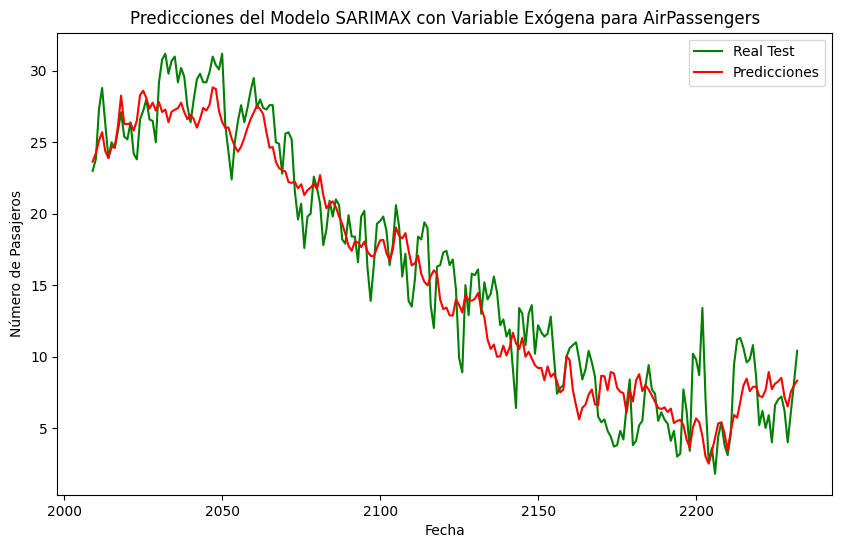

In [104]:
# Encontrar el mejor modelo SARIMAX automáticamente con pmdarima
sarimax_model = pm.auto_arima(y_train, 
                              seasonal=True, 
                              m=7,  # 12 periodos para estacionalidad anual (mensual)
                              stepwise=True, 
                              trace=True, 
                              xreg=data_train[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS']])  # Incluir la variable exógena

# Ver el resumen del modelo encontrado
print(sarimax_model.summary())

#Aplicar el modelo SARIMAX con los mejores parámetros encontrados por pmdarima
# Ajustar el modelo con los parámetros óptimos y la variable exógena
sarima_model = SARIMAX(y_train,
                       order=sarimax_model.order,  # (p, d, q) - Parámetros ARIMA
                       seasonal_order=sarimax_model.seasonal_order,  # (P, D, Q, m) - Parámetros SARIMA
                       exog=data_train[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS']])  # Incluir la variable exógena

# Ajustar el modelo SARIMAX
sarima_result = sarima_model.fit()

#Realizar predicciones
forecast = sarima_result.forecast(steps=len(y_test), exog=data_test[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS']])  # Incluir exógena en las predicciones

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y_test, label='Real Test', color='green')
plt.plot(df.index[train_size:], forecast, label='Predicciones', color='red')
plt.title('Predicciones del Modelo SARIMAX con Variable Exógena para AirPassengers')
plt.xlabel('Fecha')
plt.ylabel('Número de Pasajeros')
plt.legend()
plt.show()

c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                              tmed   No. Observations:                 2009
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -3934.125
Date:                           Wed, 26 Feb 2025   AIC                           7892.251
Time:                                   12:33:30   BIC                           7959.515
Sample:                                        0   HQIC                          7916.943
                                          - 2009                                         
Covariance Type:                             opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept           -0.0082      0.126     -0.065      0.948      -0.256       0.239
temp_med_dia_mes     0.99

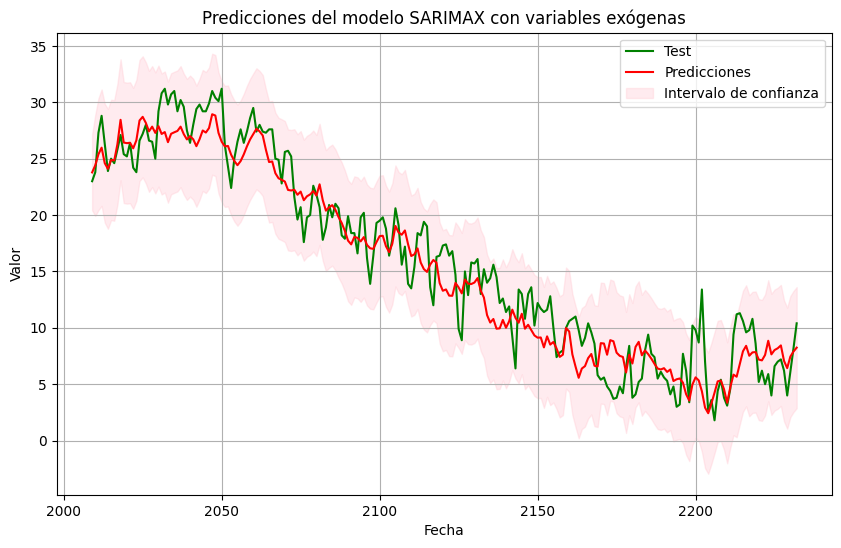

In [102]:


# 1. Supongamos que ya tienes tus datos cargados en `data_train` y `data_test`
# y_train y y_test son las series temporales objetivo
# data_train y data_test contienen las variables exógenas

# 2. Ajustar el modelo SARIMAX con variables exógenas
model = SARIMAX(
    y_train,
    exog=data_train[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano', 'MONTH_SIN', 'MONTH_COS']],  # Variables exógenas
    order=(1, 0, 1),  # Parámetros (p, d, q) del modelo ARIMA
    seasonal_order=(1, 0, 1, 7),  # Parámetros estacionales (P, D, Q, m)
    trend='c',  # Incluir una constante (tendencia)
)

# 3. Ajustar el modelo a los datos de entrenamiento
results = model.fit(disp=False)

# 4. Mostrar un resumen del modelo
print(results.summary())

# 5. Realizar predicciones sobre el conjunto de test
preds = results.get_forecast(
    steps=len(y_test),  # Número de períodos a predecir
    exog=data_test[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano', 'MONTH_SIN', 'MONTH_COS']],  # Variables exógenas para el conjunto de test
)

# 6. Obtener las predicciones y los intervalos de confianza
predicted_values = preds.predicted_mean
conf_int = preds.conf_int()

# 7. Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(data_test.index, y_test, label="Test", color="green")
plt.plot(data_test.index, predicted_values, label="Predicciones", color="red")
plt.fill_between(
    data_test.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color="pink",
    alpha=0.3,
    label="Intervalo de confianza",
)
plt.title("Predicciones del modelo SARIMAX con variables exógenas")
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.legend()
plt.grid()
plt.show()

In [107]:
rmse = root_mean_squared_error(y_test, predicted_values)
rmse

2.4445167929717293